# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [1]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-11-06 13:35:08--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  14.1MB/s    in 13s     

2021-11-06 13:35:21 (13.8 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-11-06 13:35:21--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  11.7MB/s    in 4.8s    

2021-11-06 13:35:25 (12.8 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-11-06 13:35:25--
Total wall clock time: 18s
Downloaded: 2 files, 235M in

In [2]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [3]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [4]:
# First, lets load the dataset
data_train = dset.SVHN('./', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('./', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [5]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [6]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [7]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [18]:
def train_model(model, train_loader, val_loader, loss, optimizer, num_epochs, scheduler=None):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value
        
        if scheduler is not None: # добавил к предудыщему заданию изменение по триггеру
            scheduler.step()  

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # TODO: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct_samples = 0 # правильные ответы
    total_samples = 0 # общее количество примеров
    for x, y in loader:
        x_gpu = x.to(device) # сохраняем данные на GPU (чтобы их можно было обработать)
        y_gpu = y.to(device)
        prediction = model(x_gpu) # предсказание
        _, indices = torch.max(prediction, 1) # наибольшие вероятности
        correct_samples += torch.sum(indices == y_gpu) # считаем количество совпавших с истинными ответов
        total_samples += y_gpu.shape[0] # прибавляем общее количество ответов на этом шаге
    
    val_accuracy = float(correct_samples) / total_samples # точность 

    return val_accuracy

loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader, loss, optimizer, 5)

Average loss: 0.462515, Train accuracy: 0.861294, Val accuracy: 0.849976
Average loss: 0.462503, Train accuracy: 0.861294, Val accuracy: 0.849976
Average loss: 0.462495, Train accuracy: 0.861294, Val accuracy: 0.849976
Average loss: 0.462588, Train accuracy: 0.861294, Val accuracy: 0.849976
Average loss: 0.462571, Train accuracy: 0.861294, Val accuracy: 0.849976


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [9]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50), # замена цветов
    transforms.RandomHorizontalFlip(), # отражение по горизонтали
    transforms.RandomVerticalFlip(), # отражение по вертикали
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR), # случайный поворот
    transforms.ToTensor(), # numpy images to torch images (поменять оси местами).
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20]) # приводит к -1..1, вычитая среднее и деля на СКО
])

# Create augmented train dataset
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


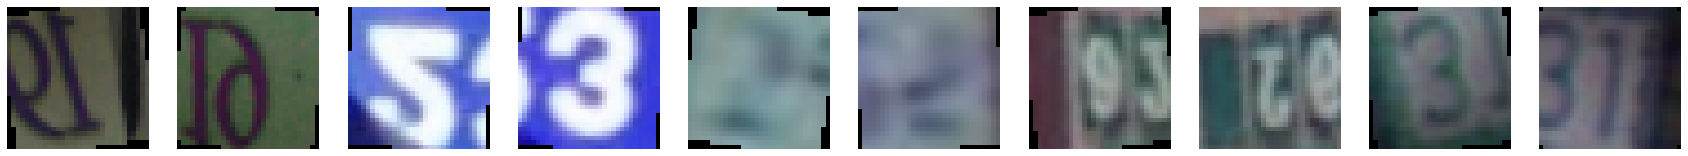

In [10]:
# TODO: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
])

data_aug_vis = dset.SVHN('./', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

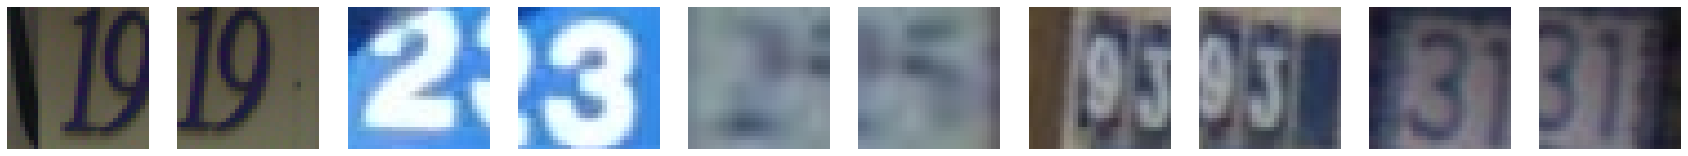

In [11]:
# сначала посмотрим примеры из исходного датасета
data_train_orig = dset.SVHN('./')

plt.figure(figsize=(30, 3))
for i, (x, y) in enumerate(data_train_orig):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

In [12]:
# проведём аугментацию данных
# TODO: 
tfs = transforms.Compose([
    # TODO: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# TODO create new instances of loaders with the augmentations you chose
# преобразование всех данных
data_aug_train = dset.SVHN('./', 
                       transform=tfs
                      )

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1231: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

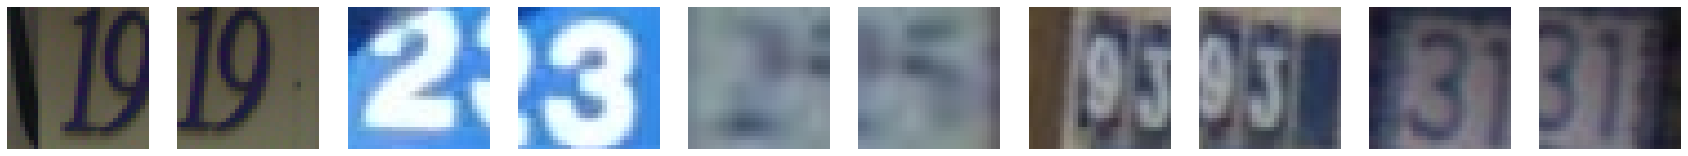

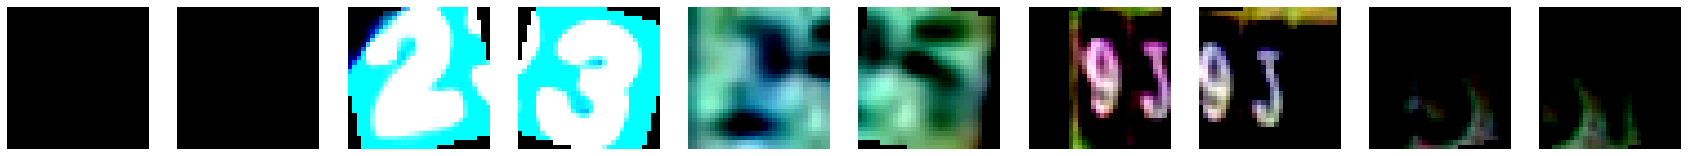

In [13]:
# теперь посмотрим на то, что было до и получилось после аугментации
data_train_orig = dset.SVHN('./')

plt.figure(figsize=(30, 3))
for i, (x, y) in enumerate(data_train_orig):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

plt.figure(figsize=(30, 3))
for i, (x, y) in enumerate(data_aug_train):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x.permute(1, 2, 0))
    plt.axis('off')

Без изменений исходных данных:
Train accuracy: 0.885814, Val accuracy: 0.732646

Подмена цветов:
Train accuracy: 0.891649, Val accuracy: 0.706232

Флипы решил не добавлять - маловероятно, что они крутятся

Цвета и повороты от -15 до +15 градусов:
Train accuracy: 0.861806, Val accuracy: 0.541601

Цвета, повороты от -15 до +15 градусов и нормализация:
Train accuracy: 0.839846, Val accuracy: 0.841854



In [14]:
# Finally, let's train with augmentations!
# разделение на батчи
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)
# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader, loss, optimizer, 5)

Average loss: 0.676655, Train accuracy: 0.791250, Val accuracy: 0.836393
Average loss: 0.608167, Train accuracy: 0.813756, Val accuracy: 0.835643
Average loss: 0.581922, Train accuracy: 0.822612, Val accuracy: 0.826633
Average loss: 0.566538, Train accuracy: 0.825615, Val accuracy: 0.842878
Average loss: 0.545835, Train accuracy: 0.832560, Val accuracy: 0.849976


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

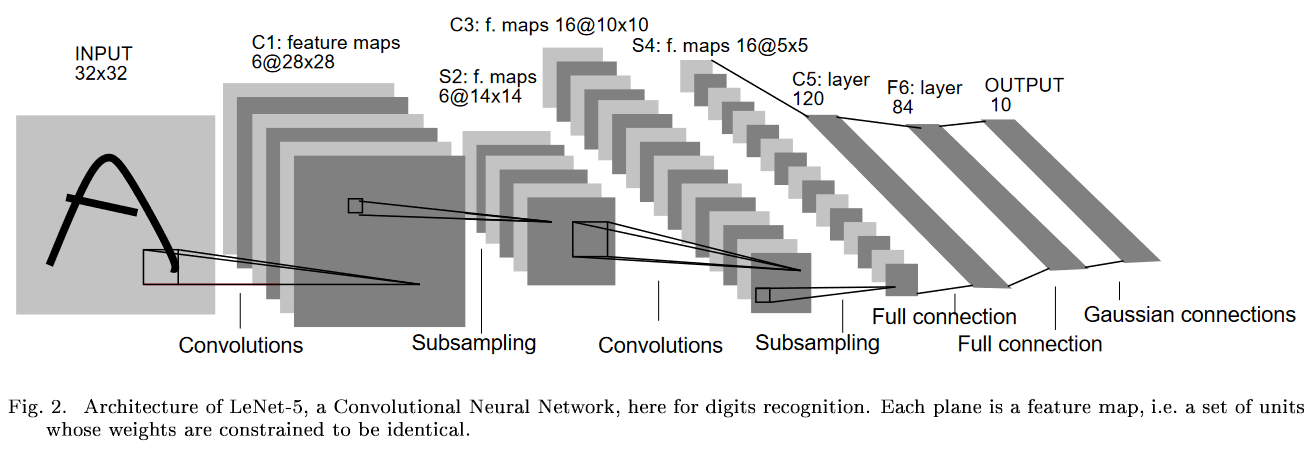


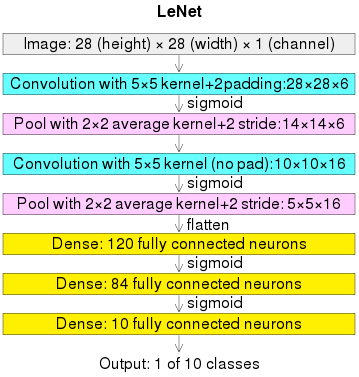

In [15]:
# TODO: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=(5, 5)), # свёртка из 3 слоёв в 6 разных ядром 5х5
    nn.MaxPool2d(kernel_size=(2, 2), stride=2), # сокращение размерности фильтром 2x2 с шагом 2
    nn.Tanh(), # функция активации (сигмоида)
    nn.Conv2d(6, 16, kernel_size=(5, 5)), # ещё свёртка с превращением 6 слоёв в 16
    nn.MaxPool2d(kernel_size=(2, 2), stride=2), # ещё пулинг
    nn.Tanh(), # и ещё активация
    Flattener(), # вытягиваем данные в одномерный вектор
    nn.Linear(16 * 5 * 5, 120), # полносвязный слой с (16 слоёв х 5х5 фильтр)=400 входными нейронами  и 120 выходными
    nn.Tanh(), # функция активации
    nn.Linear(120, 84), # полносвязный слой 120-84
    nn.Tanh(), # активация
    nn.Linear(84, 10) # полносвязный слой 84-10
          )
#nn.Sigmoid

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [16]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, 10)

Average loss: 1.343403, Train accuracy: 0.542487, Val accuracy: 0.802471
Average loss: 0.609818, Train accuracy: 0.813091, Val accuracy: 0.851136
Average loss: 0.525782, Train accuracy: 0.837491, Val accuracy: 0.860010
Average loss: 0.473702, Train accuracy: 0.853718, Val accuracy: 0.875435
Average loss: 0.446730, Train accuracy: 0.862454, Val accuracy: 0.875435
Average loss: 0.421188, Train accuracy: 0.870474, Val accuracy: 0.885127
Average loss: 0.406773, Train accuracy: 0.874825, Val accuracy: 0.877005
Average loss: 0.393163, Train accuracy: 0.879825, Val accuracy: 0.881169
Average loss: 0.376561, Train accuracy: 0.883920, Val accuracy: 0.885878
Average loss: 0.367274, Train accuracy: 0.886752, Val accuracy: 0.871203


# Подбор гиперпараметров

In [20]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e0, 1e-1, 1e-2, 1e-3, 1e-4]
anneal_coeff = 0.2
anneal_epochs = [1, 5, 10, 15, 20, 50]
regs = [1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 10 # будем учить по 10 эпох для каждой модели

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} # список опробованнных моделей и метрик точности их работы

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# TODO: Your code here!
for lr in learning_rates: # перебираем все скорости обучения
    for anneal_epoch in anneal_epochs: # отжиг
        for reg in regs: # регуляризация
            lenet_model = nn.Sequential( # модель по архитектуре LeNet
                nn.Conv2d(3, 6, kernel_size=(5, 5)),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2),
                nn.Tanh(),
                nn.Conv2d(6, 16, kernel_size=(5, 5)),
                nn.MaxPool2d(kernel_size=(2, 2), stride=2),
                nn.Tanh(),
                Flattener(),
                nn.Linear(16 * 5 * 5, 120),
                nn.Tanh(),
                nn.Linear(120, 84),
                nn.Tanh(),
                nn.Linear(84, 10)
                )

            lenet_model.type(torch.cuda.FloatTensor) # подключаем GPU
            lenet_model.to(device) # загружаем модель на GPU
            
            loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # функцию ощибок - тоже на GPU

            params = Hyperparams(lr, anneal_epoch, reg) # набор параметров для этого теста
            optimizer = optim.SGD(lenet_model.parameters(), lr=lr, weight_decay=reg) # оптимизатор
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch, gamma=anneal_coeff) # изменение модели по триггеру

            loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader, loss, optimizer, epoch_num, scheduler) # обучение модели

            result = RunResult(lenet_model, train_history, val_history, val_history[-1]) # запоминаем последние результаты по обучению в словарик
            run_record[params] = result # сохранение результата обучения

Average loss: 3.710883, Train accuracy: 0.194366, Val accuracy: 0.343253
Average loss: 1.213730, Train accuracy: 0.603351, Val accuracy: 0.705481
Average loss: 0.806750, Train accuracy: 0.748388, Val accuracy: 0.785953
Average loss: 0.725268, Train accuracy: 0.773897, Val accuracy: 0.796123
Average loss: 0.705726, Train accuracy: 0.779221, Val accuracy: 0.799331
Average loss: 0.705320, Train accuracy: 0.780807, Val accuracy: 0.799331
Average loss: 0.702945, Train accuracy: 0.781780, Val accuracy: 0.799195
Average loss: 0.701563, Train accuracy: 0.782377, Val accuracy: 0.799195
Average loss: 0.702987, Train accuracy: 0.781234, Val accuracy: 0.799126
Average loss: 0.703814, Train accuracy: 0.781405, Val accuracy: 0.799126
Average loss: 6.327934, Train accuracy: 0.124834, Val accuracy: 0.118012
Average loss: 2.331007, Train accuracy: 0.158789, Val accuracy: 0.161900
Average loss: 2.234321, Train accuracy: 0.183326, Val accuracy: 0.192205
Average loss: 2.222227, Train accuracy: 0.189793, V

KeyboardInterrupt: ignored

In [21]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.87, best hyperparams: Hyperparams(learning_rate=1.0, anneal_epochs=5, reg=0.001)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [22]:
best_model = nn.Sequential(
              nn.Conv2d(3, 64, kernel_size=(3, 3)),
              nn.MaxPool2d(kernel_size=(2, 2), stride=2),
              nn.BatchNorm2d(64), # добавлена нормализация по батчам
              nn.ReLU(inplace=True), # замена функции активации на ReLU
              
              # второй свёрточный слой
              nn.Conv2d(64, 256, kernel_size=(3, 3)),
              nn.MaxPool2d(kernel_size=(2, 2), stride=2),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),
              
              # три свёрточных слоя вместо двух
              nn.Conv2d(256, 256, kernel_size=(3, 3)),
              nn.MaxPool2d(kernel_size=(2, 2), stride=2),
              nn.BatchNorm2d(256),
              nn.ReLU(inplace=True),

              Flattener(), # выравнивание для полносвязных слоёв
              nn.Linear(256 * 2 * 2, 120), # полносвязный слой для выбора сильных признаков
              nn.BatchNorm1d(120),
              nn.ReLU(inplace=True),

              nn.Linear(120, 10) # полносвязный слой для понимания по сильным признакам, какой класс
            )

best_model.type(torch.cuda.FloatTensor) # модель для GPU
best_model.to(device) # сохранение модели на GPU

optimizer = optim.Adam(best_model.parameters(), lr=1e-3, weight_decay=1e-5) # замена SGD на Adam
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=1e-4, max_lr=1e-3, cycle_momentum=False)

loss_history, train_history, val_history = train_model(best_model, train_aug_loader, val_loader, loss, optimizer, 20, scheduler)

Average loss: 1.078968, Train accuracy: 0.691550, Val accuracy: 0.857006
Average loss: 0.520047, Train accuracy: 0.852711, Val accuracy: 0.885196
Average loss: 0.407449, Train accuracy: 0.881036, Val accuracy: 0.899666
Average loss: 0.349635, Train accuracy: 0.895744, Val accuracy: 0.910586
Average loss: 0.311264, Train accuracy: 0.906665, Val accuracy: 0.910177
Average loss: 0.283639, Train accuracy: 0.916032, Val accuracy: 0.915910
Average loss: 0.259416, Train accuracy: 0.923711, Val accuracy: 0.916729
Average loss: 0.237700, Train accuracy: 0.929376, Val accuracy: 0.916183
Average loss: 0.217588, Train accuracy: 0.935314, Val accuracy: 0.919801
Average loss: 0.206099, Train accuracy: 0.938812, Val accuracy: 0.919596
Average loss: 0.192030, Train accuracy: 0.943026, Val accuracy: 0.918094
Average loss: 0.177849, Train accuracy: 0.946661, Val accuracy: 0.917617
Average loss: 0.165803, Train accuracy: 0.949561, Val accuracy: 0.920142
Average loss: 0.156029, Train accuracy: 0.952599, V

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [23]:
# TODO Write the code to compute accuracy on test set
final_test_accuracy = 0.0
test_loader = torch.utils.data.DataLoader(data_test, batch_size=batch_size) # загрузка тестовых данных
final_test_accuracy = compute_accuracy(best_model, test_loader) # точность на тестовых данных
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9183312845728334
